<a href="https://colab.research.google.com/github/SherstennikovDaniil/cs102/blob/homework10/homework10-ds/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Классификация

Вы уже встречались с задачей классификации в работе [«Персонализация новостной ленты Hacker News»](http://127.0.0.1:4000/2017/11/22/06-hackernews/). В общем виде задачу классификации можно представить следующим образом: имеется множество объектов, которые разделены на классы по некоторым признакам. Например, успевающие студенты и отстающие студенты. В обучающей выборке задано конечное множество объектов и их признаков. Например, перечень всех студентов учебного заведения и все оценки по прошедшим и текущим дисциплинам. Для каждого из объектов обучающей выборки известно, к каким классам они относятся. Принадлежность же остальных объектов к классам неизвестна. Требуется построить алгоритм, способный классифицировать произвольный объект из исходного множества, то есть указать наименование (или номер) класса, к которому объект отнесён в результате применения алгоритма классификации.

### *Логистическая регрессия*

Давайте рассмотрим логистическую регрессию на примере набора данных цветов ириса.

Для простоты будем использовать только два признака `Sepal Width` и `Sepal Length`, а также два класса `Setosa` и `Versicolor`:

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
%matplotlib inline

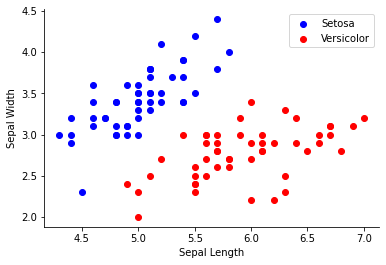

In [ ]:
data = datasets.load_iris()
X = data.data[:100, :2]
y = data.target[:100]

setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:,0], X[50:,1], c='r')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend((setosa, versicolor), ("Setosa", "Versicolor"))
sns.despine()

Итак, наша задача построить разделяющую границу (decision boundary), которая бы позволила нам отделить наблюдения одного класса (`Setosa`) от другого (`Versicolor`). Одним из напрашиваемых решений является представление зависимой переменной в виде линейной комбинации признаков (по аналогии с линейной регрессией):

$$
y_i = \theta_0 + \theta_1 SW_{i} + \theta_2 SL_{i}
$$

Предположим, что у нас есть наблюдение с признаками $SW = 3.5$ и $SL = 5$. И кто-то сказал нам, что $\theta_0 = 1$, $\theta_1 = 2$ и $\theta_2 = 4$, тогда:

$$
y_i = 1 + 2 * 3.5 + 4 * 5 = 28
$$

Во-первых, как мы должны интерпретировать значене $28$? Во-вторых, модель в таком виде подходит для прогнозирования непрерывных значений, которые ограничены бесконечностью:

$$
-\infty \le \theta^{T}x \le +\infty
$$
В действительности мы хотим построить модель, которая позволит нам прогнозировать бинарный отклик, а точнее вероятность отнесения наблюдения к одному из классов, то есть:
$$
P(y=1 \mid x) = f(\theta^{T}x)
$$

$$
P(y=0 \mid x) = 1 - f(\theta^{T}x)
$$

Где:

$$
0 \le f(\theta^{T}x) \le 1
$$


Такой функцией $f$ может быть **логистическая функция**:

$$
P(y = 1 \mid x) = \frac{e^{\theta^{T}x}}{1 + e^{\theta^{T}x}} = \frac{1}{1 + e^{-\theta^{T}x}}
$$

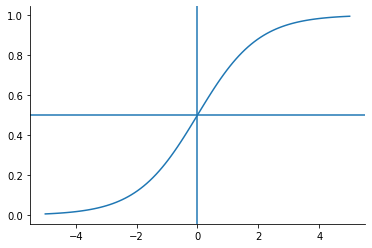

In [ ]:
x_values = np.linspace(-5, 5, 100)
y_values = [1 / (1 + math.e**(-x)) for x in x_values]
plt.plot(x_values, y_values)
plt.axhline(.5)
plt.axvline(0)
sns.despine()

Отметим, что значение вероятности, описываемое логистической функцией, ограничено диапазоном значений от 0 до 1, а также то, что большие изменения вероятности требуют больших изменений в $x$, чем для значений вероятности близких к 0.5.

Возвращаясь к нашему примеру:

$$
P(y = 1 \mid x) = \frac{1}{1 + e^{-(\theta_0 + \theta_1 SW_{i} + \theta_2 SL_{i})}} = \frac{1}{1 + e^{-28}} = 0.99
$$


Таким образом, с вероятностью 0.99 мы можем отнести наше наблюдение к классу `Setosa`.

Как мы будем находить параметры $\theta_i$? Для начала нам необходимо определиться с видом целевой функции. Так как наша модель прогнозирует вероятности, то мы можем использовать принцип максимального правдоподобия.

Для краткости, можем записать функцию распределения $y$ при заданном $x$ в следующем виде:

$$
P(y = y_i \mid x) = P(y_i = 1 \mid x_i)^{y_{i}} (1 - P(y_i = 1 \mid x_i))^{1 - y_{i}}
$$


Фактически, это есть распределение Бернулли.

В зависимости от значения $y$ одна из двух частей уравнения будет равна 1. 

Для $y=1$:

$$
P(y = 1 \mid x) = P(y_i = 1 \mid x_i)^1 (1 - P(y_i = 1 \mid x_i))^{1 - 1} = P(y_i = 1 \mid x_i)
$$


Для $y=0$:

$$
P(y = 0 \mid x) = P(y_i = 1 \mid x_i)^0 (1 - P(y_i = 1 \mid x_i))^{1 - 0} = 1 - P(y_i = 1 \mid x_i)
$$


Правдоподобие для $m$ наблюдений можно записать как:

$$
L = \prod_{i=1}^{m}P(y = y_i \mid x_i) = \prod_{i=1}^{m}P(y = 1 \mid x_i)^{y_i}(1 - P(y_i = 1 \mid x_i))^{1 - y_i}
$$

$$
\log L = \sum_{i=1}^{m} y_i \times \log(P(y = 1 \mid x_i)) + (1 - y_i) \times \log(1 - P(y_i = 1 \mid x_i))
$$


Введем обозначение:

$$
p_i = P(y = 1 \mid x_i)
$$

Тогда функция правдоподобия может быть записана как:

$$
\log L = \sum_{i=1}^{m} y_i \times \log(p_i) + (1 - y_i) \times \log(1 - p_i))
$$


Таким образом, мы можем записать нашу целевую функцию:

$$
J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} y_i \times \log(p_i) + (1 - y_i) \times \log(1 - p_i))
$$


Чтобы найти параметры $\theta$ мы можем воспользоваться методом градиентного спуска. Вспомним правило обновления весов:

$$
\theta := \theta - \alpha \frac{\partial}{\partial \theta}J(\theta)
$$


Где:
$$
\frac{\partial}{\partial \theta}J(\theta)
$$

Вывод производных см. [тут](http://ronny.rest/blog/post_2017_08_12_logistic_regression_derivative/).
</div>
$$
\frac{\partial}{\partial \theta}J(\theta) = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}
$$


$$
h_{\theta}(x) = f(\theta^Tx) = \frac{1}{1 + e^{-\theta^{T}x}}
$$

$$
f(z) = \frac{1}{1 + e ^{-z}}
$$


В результате подстановки получим следующее правило для пересчета параметров $\theta$:

$$
\theta := \theta - \alpha\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x_i)-y_i)x_i
$$

### *Пример с использованием библиотеки sklearn*


In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sum(y_test == y_pred) # 30

30

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred) # 1

1.0

Давайте рассмотрим другой пример, для которого сгенеируем набор данных из 10 тысяч наблюдений:

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=10, n_classes=2, n_informative=5, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = linear_model.LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
sum(y_test == y_pred) # 2306

2306

In [ ]:
accuracy_score(y_test, y_pred) # 0.76866666666666672

0.7686666666666667

Значение $0.7687$ ничего не говорит нам об ошибках [первого и второго рода](https://ru.wikipedia.org/wiki/%D0%9E%D1%88%D0%B8%D0%B1%D0%BA%D0%B8_%D0%BF%D0%B5%D1%80%D0%B2%D0%BE%D0%B3%D0%BE_%D0%B8_%D0%B2%D1%82%D0%BE%D1%80%D0%BE%D0%B3%D0%BE_%D1%80%D0%BE%D0%B4%D0%B0). Мы можем построить матрицу ошибок $C$, чтобы получить более полное представление.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred) # array([[1129,  363], [ 331, 1177]])

array([[1129,  363],
       [ 331, 1177]])

где:

- $C_{0,0} = 1129$ – True Negatives (TN), истинное значение 0, предсказанное 0
- $C_{1,0} = 331$ – False Negatives (FN), истинное значение 1, предсказанное 0
- $C_{0,1} = 363$ – False Positives (FP), истинное значение 0, предсказанное 1
- $C_{1,1} = 1177$ – True Positives (TP), истинное значение 1, предсказанное 1

И наконец мы можем построить ROC-кривую (https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/) для визуальной оценки точности работы классификатора:

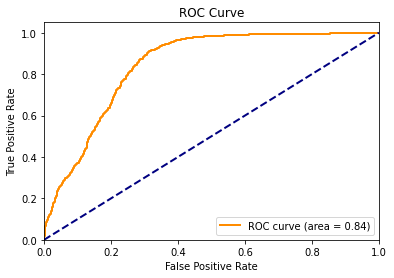

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_pred, y_test):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

y_pred = model.predict_proba(X_test)[:,1]
plot_roc_curve(y_pred, y_test)

### *Многоклассовая классификация*

In [ ]:
data = datasets.load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = linear_model.LogisticRegression(multi_class='ovr')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(sum(y_test == y_pred)) # 42
print(accuracy_score(y_test, y_pred)) #0.93333333333333335
print(confusion_matrix(y_test, y_pred)) # array([[12,  0,  0], [ 0, 16,  3], [ 0,  0, 14]])

44
0.9777777777777777
[[12  0  0]
 [ 0 18  1]
 [ 0  0 14]]


In [ ]:
def plot_roc_curve(y_predict_proba, y_test, n_classes=3):
    # Compute ROC curve and ROC AUC for each class
    n_classes = 3
    fpr = {}
    tpr = {}
    roc_auc = {}
    all_y_test_i = np.array([])
    all_y_predict_proba = np.array([])

    for i in range(n_classes):
        y_test_i = [1 if yi == i else 0 for yi in y_test]
        all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
        all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
        fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
    roc_auc["average"] = auc(fpr["average"], tpr["average"])

    # Plot average ROC Curve
    plt.figure()
    plt.plot(fpr["average"], tpr["average"],
        label='Average ROC curve (area = {0:0.2f})'.format(roc_auc["average"]),
        color='deeppink', linestyle=':', linewidth=4)

    # Plot each individual ROC curve
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

### *Задание*

In [ ]:
import scipy

In [ ]:
class LogisticRegression:
    def __init__(self, alpha=0.01, max_iter=1000):
        self.theta = None
        self.alpha = alpha
        self.max_iter = max_iter

    def _init_theta(self, X):
      n_features = X.shape[1]
      lim = 1.0 / np.sqrt(n_features)
      return np.random.uniform(-lim, lim, (n_features, ))

    def fit(self, X_train, y_train):
      X_train = np.insert(X_train, 0, 1, axis=1)
      self.theta = []

      for i in np.unique(y_train):
        y_copy = np.where(y_train == i, 1, 0)
        theta_partial = self._init_theta(X_train) # np.ones(X_train.shape[1])

        for _ in np.arange(self.max_iter):
          output = X_train.dot(theta_partial)
          errors = y_copy - self._sigmoid(output)
          theta_partial += self.alpha * errors.T.dot(X_train)
        self.theta.append([theta_partial, i])
      
      self.theta = np.asarray(self.theta, dtype=object)

    def predict(self, X_test):
      return np.asarray([self._predict_partial(i) for i in np.insert(X_test, 0, 1, axis=1)])

    def _predict_partial(self, x):
      return max((x.dot(i[0]), i[1]) for i in self.theta)[1]

    def predict_proba(self, X_test):
      prob = self._sigmoid(X_test)
      scipy.special.expit(prob, out=prob)
      if prob.ndim == 1:
          return np.vstack([1 - prob, prob]).T
      else:
          prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
          return prob

    def _sigmoid(self, x):
      return 1.0 / (1 + np.exp(-x))

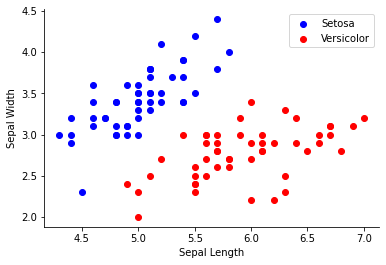

In [ ]:
data = datasets.load_iris()
X = data.data[:100, :2]
y = data.target[:100]

setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:,0], X[50:,1], c='r')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend((setosa, versicolor), ("Setosa", "Versicolor"))
sns.despine()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sum(y_test == y_pred)

30

In [ ]:
model.theta

array([[array([ 2.76360099, -5.82874404,  9.28130771]), 0],
       [array([-3.03981444,  5.85528026, -9.23785573]), 1]], dtype=object)

In [ ]:
accuracy_score(y_test, y_pred)

1.0

In [ ]:
def plot_roc_curve(y_pred, y_test):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

y_pred_probs = model.predict_proba(X_test)[:,1]

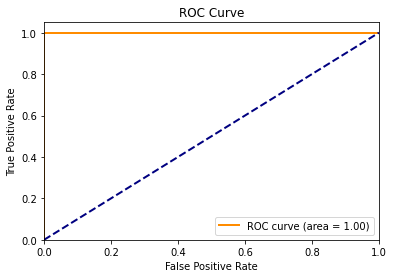

In [ ]:
plot_roc_curve(y_pred, y_test)

Проверим на случайных данных:

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=10, n_classes=2, n_informative=5, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = LogisticRegression(alpha=5735e-7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
sum(y_test == y_pred) # 2306

2356

In [ ]:
accuracy_score(y_test, y_pred)

0.7853333333333333

In [ ]:
confusion_matrix(y_test, y_pred)

array([[1075,  417],
       [ 227, 1281]])

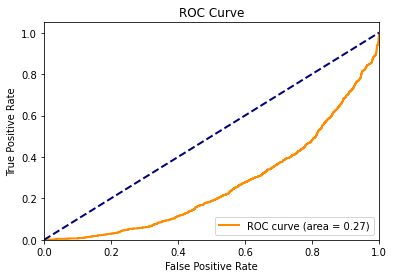

In [ ]:
def plot_roc_curve(y_pred, y_test):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

y_pred = model.predict_proba(X_test)[:,1]
plot_roc_curve(y_pred, y_test)

#### Пример с многоклассовой классификацией

In [ ]:
data = datasets.load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(sum(y_test == y_pred)) # 42
print(accuracy_score(y_test, y_pred)) #0.93333333333333335
print(confusion_matrix(y_test, y_pred)) # array([[12,  0,  0], [ 0, 16,  3], [ 0,  0, 14]])

39
0.8666666666666667
[[12  0  0]
 [ 0 16  3]
 [ 0  3 11]]


In [ ]:
def plot_roc_curve(y_predict_proba, y_test, n_classes=3):
    # Compute ROC curve and ROC AUC for each class
    n_classes = 3
    fpr = {}
    tpr = {}
    roc_auc = {}
    all_y_test_i = np.array([])
    all_y_predict_proba = np.array([])

    for i in range(n_classes):
        y_test_i = [1 if yi == i else 0 for yi in y_test]
        all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
        all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
        fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
    roc_auc["average"] = auc(fpr["average"], tpr["average"])

    # Plot average ROC Curve
    plt.figure()
    plt.plot(fpr["average"], tpr["average"],
        label='Average ROC curve (area = {0:0.2f})'.format(roc_auc["average"]),
        color='deeppink', linestyle=':', linewidth=4)

    # Plot each individual ROC curve
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

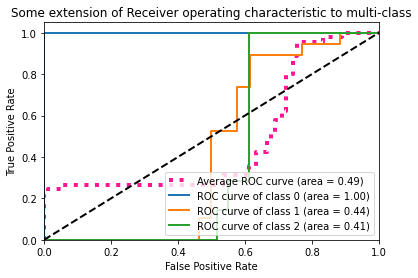

In [ ]:
plot_roc_curve(model.predict_proba(X_test), model.predict(X_test), n_classes=3)